# Data Augmentation

Data Augmentation is a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation.

## Setup

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 391.8MB 37kB/s 
     |████████████████████████████████| 471kB 47.7MB/s 
     |████████████████████████████████| 10.2MB 39.4MB/s 


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Download a dataset

In [22]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

The flowers dataset has five classes.

In [23]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

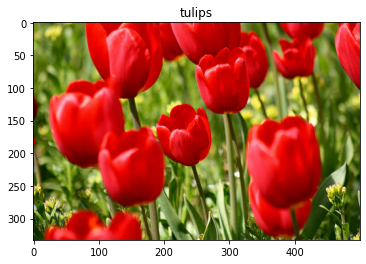

In [24]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras preprocessing layers

### Resizing and rescaling

Use preprocessing layers to resize your images to a consistent shape, and to rescale pixel values.

In [25]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

You can see the result of applying these layers to an image.

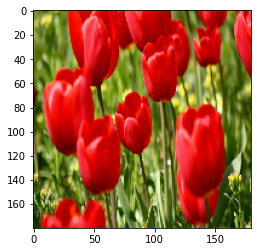

In [26]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

You can verify the pixels are in [0-1].

In [27]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

Use preprocessing layers for data augmentation. Create a few preprocessing layers and apply them repeatedly to the same image.

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

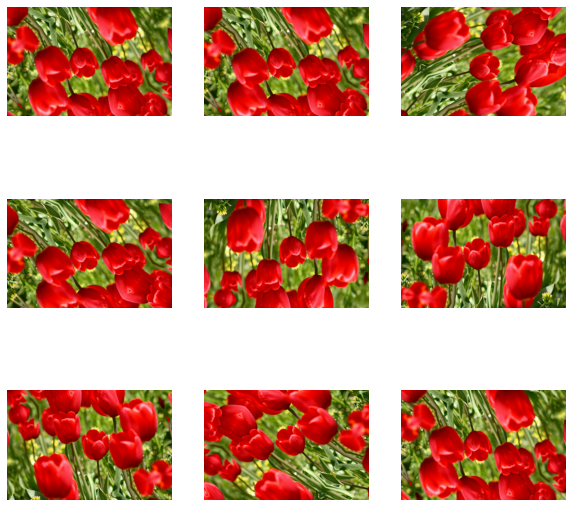

In [30]:
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing layers that can be used for data augmentation including `layers.RandomContrast`, `layers.RandomCrop`, `layers.RandomZoom`, and others.

### Two options to use the preprocessing layers

There are two ways to use these preprocessing layers, with important tradeoffs.

#### Option 1: Make the preprocessing layers part of your model

In [31]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D()
])

There are two important points to be aware of in this case:

- Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
- When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

#### Option 2: Apply the preprocessing layers to your dataset

In [32]:
aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

- Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
- In this case the prepreprocessing layers will not be exported with the model when you call `model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

### Apply the preprocessing layers to the datasets

Configure the train, validation, and test datasets with the preprocessing layers you created above. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking.

In [33]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resie and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)
  
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
    
  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [34]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

In [35]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
epochs = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 103s 1s/step - loss: 1.4528 - accuracy: 0.3671 - val_loss: 1.0817 - val_accuracy: 0.5259
Epoch 2/5
92/92 [==============================] - 104s 1s/step - loss: 1.0924 - accuracy: 0.5628 - val_loss: 1.0036 - val_accuracy: 0.5940
Epoch 3/5
92/92 [==============================] - 101s 1s/step - loss: 0.9967 - accuracy: 0.5996 - val_loss: 0.9455 - val_accuracy: 0.6540
Epoch 4/5
92/92 [==============================] - 101s 1s/step - loss: 0.9196 - accuracy: 0.6420 - val_loss: 0.8874 - val_accuracy: 0.6839
Epoch 5/5
92/92 [==============================] - 100s 1s/step - loss: 0.8767 - accuracy: 0.6558 - val_loss: 0.9249 - val_accuracy: 0.6621


In [38]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 311ms/step - loss: 0.8402 - accuracy: 0.6839
Accuracy 0.6839237213134766


### Custom data augmentation

First, create a `layers.lambda` layer. Then, write a new layer via subclassing, which gives mroe control. Both layers will randomly invert the colors in an image, accoring to some probability.

In [39]:
def random_invert_img(x, p=0.5):
  if tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [40]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

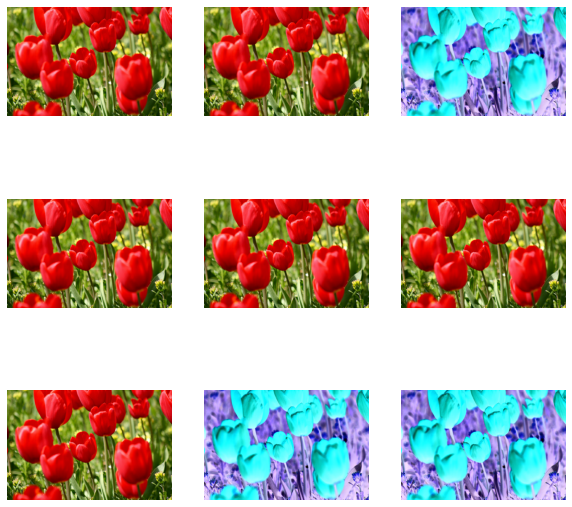

In [41]:
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by subclassing.

In [45]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

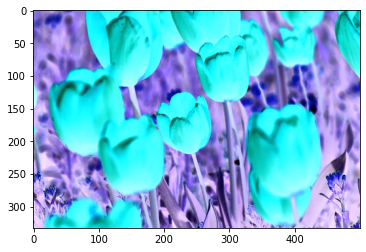

In [46]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

## Using tf.image

For finer control, you can write your own data augmentation pipelines or layers using `tf.data` and `tf.image`.

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh.

In [47]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with.

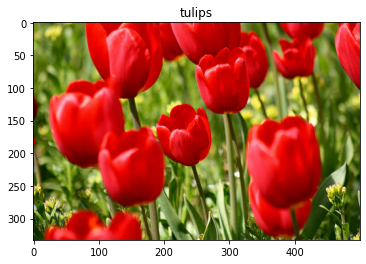

In [48]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side.

In [50]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Data augmentation

#### Flipping the image

Flip the image either vertically or horizontally.

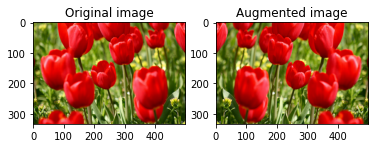

In [51]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### Grayscale the image

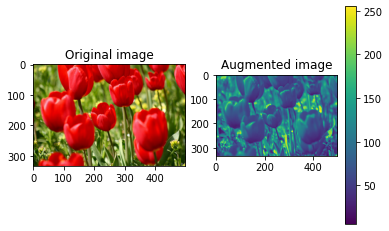

In [52]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### Saturate the image
Saturate an image by providing a saturation factor.

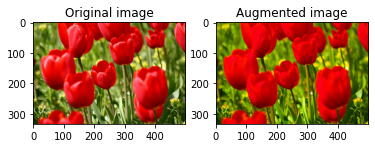

In [53]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### Change image brightness
Change the brightness of image by providing a brightness factor.

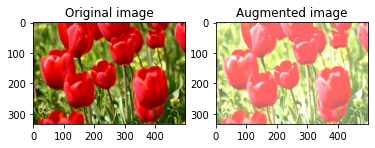

In [54]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### Center crop the image
Crop the image from center up to the part you desire.

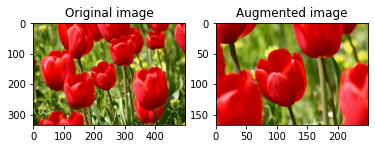

In [55]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

#### Rotate the image
Rotate an image by 90 degrees.

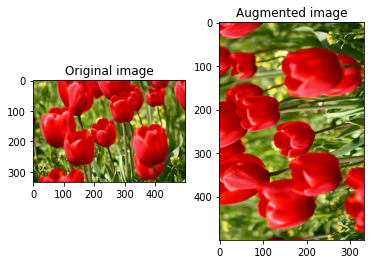

In [56]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### Apply augmentation to a dataset

As before, apply data augmentaton to a dataset using `Dataset.map`.

In [57]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [58]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### Configure the datasets

In [59]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
) 

In [60]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [61]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model!